# XAS Workflow Task 2

This notebook contains the second task of the XAS processing workflow. 

The break up of the task consist of the following steps 

|Task                            | Input                                         | Output
|-------------                   |-------------                                  |-----  
| Curve fitting||
| 1. Import data                |File: FeS2_larch.prj                              |
| 2. Import Crystal data        |File: FeS2.inp                                 |
| 3. Calculate Paths(Atoms+FEFF)||
| 4. Set path parameters        | Parameters:                                   |
|                                 |    amp  = 1                                   |
|                                 |    enot = 0                                   |
|                                 |    delr = 0                                   |
|                                 |    ss   = 0.003                               |
| 5. Select paths                 |                                               |
| 6. Run Fit                    |                                               |
| 7. Save project               ||
| 8. Verify fit results         ||
| 8.1 If not OK revise parameners and refit (go to 2.4)||
| 8.2 If OK Save project and outputs|                                           |File: FeS2_01.fpj

For more details about larch, see https://xraypy.github.io/xraylarch/xafs/


In [1]:
# Library with the functions that handle athena files
import lib.manage_athena as athenamgr     

# define the name of the input file
athena_file = 'FeS2_larch.prj'

# read the input file 
athena_prj = athenamgr.read_project(athena_file)

athena_groups = athenamgr.get_groups(athena_prj)

group_names = []
for a_group in athena_groups:
    group_names.append(a_group.label)
    
group_names

# recalculate norm, background removal and fourier transform 
# with defaults
data_group = athenamgr.calc_with_defaults(athena_groups[0])

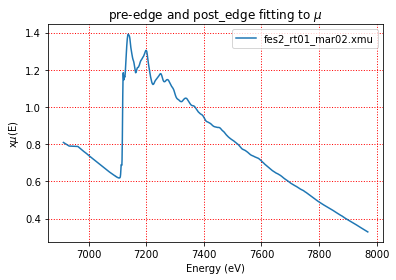

In [2]:
# direct plotting to the results after running the cells
%matplotlib inline

# plot normalised mu on energy
# plot mu vs flat normalised mu for selected groups
for a_group in athena_groups:
    athenamgr.plot_normalised(a_group)


## Atoms and FEFF 

Larch does larch does not include a means for running atoms. Atoms is needed to get input for feff and calculate paths. Currently, the fastest option is to run Artemis to obtain the input (.inp) file for feff from a crystal file ('.cif' or '.inp')

The code below shows how subprocess can be used to call perl, execute a small perl script that runs Artemis Atoms, and saves the output file ('inp') in a new directory.

The file can then be used to run FEFF from Larch to calculate scattering paths.

In [3]:
# Library with the functions that execute 
# Atoms and FEFF to generate scattering paths
import lib.atoms_feff as feff_runner     
# get the input files as a list so more than one 
# crystal file can be used in fitting
crystal_files = ["FeS2.inp","FeS.inp"]
# run feff and get a list of feff dirs
feff_dirs = feff_runner.run_feff(crystal_files)

 : ======== running Feff module C:\Users\scman1\Anaconda3\envs\python36\lib\site-packages\larch\bin\win32\feff6l.exe ========
 : Feff 6L.02
 : name:     Iron sulfide (pyrite)
 : formula:  FeS_2
 : refer1:   Elliot (1960) J.Chem. Phys. 33(3), 903.
 : Calculating potentials and phases...
 : free atom potential and density for atom type    0
 : free atom potential and density for atom type    1
 : free atom potential and density for atom type    2
 : overlapped potential and density for unique potential    0
 : overlapped potential and density for unique potential    1
 : overlapped potential and density for unique potential    2
 : muffin tin radii and interstitial parameters
 : phase shifts for unique potential    0
 : phase shifts for unique potential    1
 : phase shifts for unique potential    2
 : Preparing plane wave scattering amplitudes...
 : nncrit in prcrit       9
 : Searching for paths...
 : Rmax  6.0000  keep and heap limits   0.0000000   0.0000000
 : Preparing neighbor tabl

## Set Parameters
The code for managing the parameters group (GDS in Artemis) is stored in lib/manage_gds.py. 

The following two cells show how the functions of manage_gds.py are used to read GDS parameters from a file, display the parameters and save them after they have been modified

The parameter values are the same used in [Bruce Ravel's example](https://github.com/bruceravel/demeter/tree/master/examples/recipes/FeS2).

In [4]:
# Set parameters          
# library containign functions tho manage fit, at read, write 
# GDS parameters, and scattering paths. 
# GSD parameters and scattering paths are saved to csv files.
from larch import Interpreter

session = Interpreter()

import lib.manage_fit as fit_manager       

# define the name of the input gds file
gds_file = 'FeS2_gds.csv'
# read save parameters from input gds file
gds = fit_manager.read_gds(gds_file, session)
# show gsd group parameters in a spreadsheet
this_sheet = fit_manager.show_gds(gds)
# save gsd group parameters in a csv file
fit_manager.save_gds(gds, gds_file)

Sheet(cells=(Cell(column_start=0, row_end=17, row_start=0, squeeze_column=False, squeeze_row=False, value=[['i…

In [5]:
#read the gds data and save it to the csv file
gds = fit_manager.spreadsheet_to_gds(this_sheet, session)
# save gsd group parameters in a csv file
fit_manager.save_gds(gds, gds_file)

## Select Paths
The selection of scattering paths aims at obtaining a list of paths to be used for the fit. For Larch the list must contain specially built *FeffPathGroup* objects. The creation of the path list has been separated in three stages: 
1. **Show feff paths** and allow selecting the ones to be used
2. Show selected paths **Assing parameters** and allow assigning parameters to them
3. **Create selected paths list** contating *FeffPathGroup* objects from larch

   The goal is to obtain a list of 
The first activity requires selecting paths from the FEFF directory. These paths are stored by feff in the files.dat

Each scattering path is loaded while setting the amplitude, $\Delta E_0$, $\Delta R$ and $\sigma^2$ parameters using the GDS parameters defined previously.

The groups are then added to a list of paths to be used for the fit.

### 1 Show all FEFF paths 

To select a path change the value of the select column to 1 in the table displayed after running the cell below.


In [6]:
path_sheet = fit_manager.show_feff_paths('FeS2.inp')
display(path_sheet)


[root] INFO : FeS2_feff path and FeS2_feff\files.dat found
[root] INFO : Reading from: FeS2_feff\files.dat
[root] INFO : 1: name:     Iron sulfide (pyrite)                        Feff 6L.02  potph 4.12
[root] INFO : 2: formula:  FeS_2
[root] INFO : 3: refer1:   Elliot (1960) J.Chem. Phys. 33(3), 903.
[root] INFO : 4: Abs   Z=26 Rmt= 1.116 Rnm= 1.361 K shell
[root] INFO : 5: Pot 1 Z=26 Rmt= 1.121 Rnm= 1.372
[root] INFO : 6: Pot 2 Z=16 Rmt= 1.120 Rnm= 1.390
[root] INFO : 7: Gam_ch=1.325E+00 H-L exch
[root] INFO : 8: Mu=-4.281E+00 kf=2.108E+00 Vint=-2.122E+01 Rs_int= 1.720
[root] INFO : 9: -------------------------------------------------------------------------------
[root] INFO : headers:['file', 'sig2', 'amp_rati', 'deg', 'nlegs', 'r_effective']


Sheet(cells=(Cell(column_end=6, column_start=0, row_end=48, row_start=0, squeeze_column=False, squeeze_row=Fal…

### 2 Assing parameters to paths
To define the parameters enter values like those presented in the table below into the spreadsheet that appears after running the code in the following cell. The values should correspond to those defined as GDS parameters previously.

|file                  |label | s02 |e0   |sigma2 |deltar      |
|----------------------|------|-----|-----|-------|------------|
|FeS2_feff/feff0001.dat|S1    |amp  |enot |ss     |alpha\*reff |
|FeS2_feff/feff0002.dat|S2    |amp  |enot |ss2    |alpha\*reff |
|FeS2_feff/feff0003.dat|S3    |amp  |enot |ss3    |alpha\*reff |
|FeS2_feff/feff0004.dat|Fe    |amp  |enot |ssfe   |alpha\*reff |


**Note:** Labelling is used for reference only using Artemis-FEFF given names. Larch's FEFF does not label paths.

In [8]:
sp_sheet = fit_manager.show_selected_paths(path_sheet)


Sheet(cells=(Cell(column_end=5, column_start=0, row_end=4, row_start=0, squeeze_column=False, squeeze_row=Fals…

In [9]:
# library containign functions that read and write to csv files
import lib.handle_csv as csvhandler

from larch import Interpreter

import larch_plugins as lp


# use data frame to create selected paths list
def build_selected_paths_list(sp_sheet):
    df_sheet = ipysheet.to_dataframe(sp_sheet).transpose()
    sp_list = []
    for col in df_sheet:
        if df_sheet[col][0] != 'file':
            new_path = lp.xafs.FeffPathGroup(filename = df_sheet[col][0],
                                             label    = df_sheet[col][1],
                                             s02      = df_sheet[col][2],
                                             e0       = df_sheet[col][3],
                                             sigma2   = df_sheet[col][4],
                                             deltar   = df_sheet[col][5],
                                             _larch   = session)
            sp_list.append(new_path)
    return sp_list

def save_selected_paths_list(sp_sheet, f_prefix = "FeS2"):
    # it is easier to transpose as dataframes main objects are columns
    df_sheet = ipysheet.to_dataframe(sp_sheet).transpose()
    sp_list = {}
    path_count = 1
    for col in df_sheet:
        if df_sheet[col][0] != 'file':
            sp_list[path_count] = {'id': path_count,
                                   'filename':df_sheet[col][0],
                                   'label':df_sheet[col][1],
                                   's02':df_sheet[col][2],
                                   'e0':df_sheet[col][3],
                                   'sigma2':df_sheet[col][4],
                                   'deltar':df_sheet[col][5]}
            path_count += 1
    print(sp_list)
    file_name = f_prefix+"_sp.csv"
    csvhandler.write_csv_data(sp_list,file_name)
    
f_prefix = "FeS2"
selected_paths = fit_manager.build_selected_paths_list(sp_sheet, session)
fit_manager.save_selected_paths_list(sp_sheet)

{1: {'id': 1, 'filename': 'FeS2_feff/feff0001.dat', 'label': 'S1', 's02': 'amp', 'e0': 'enot', 'sigma2': 'ss', 'deltar': 'alpha*reff'}, 2: {'id': 2, 'filename': 'FeS2_feff/feff0002.dat', 'label': 'S2', 's02': 'amp', 'e0': 'enot', 'sigma2': 'ss2', 'deltar': 'alpha*reff'}, 3: {'id': 3, 'filename': 'FeS2_feff/feff0003.dat', 'label': 'S3', 's02': 'amp', 'e0': 'enot', 'sigma2': 'ss3', 'deltar': 'alpha*reff'}, 4: {'id': 4, 'filename': 'FeS2_feff/feff0004.dat', 'label': 'Fe', 's02': 'amp', 'e0': 'enot', 'sigma2': 'ssfe', 'deltar': 'alpha*reff'}}


## Run Fit

XAS fitting is performed in three steps:
1. Create a Transform group to holds the set of Fourier transform parameters, fitting ranges, and space in which the data and sum of paths are to be compared (R space)
2. Create a Dataset group,consistaining of the three components required for fitting(data, paths, and transform group)
3. FEFFIT is run with the list of parameters (gds) for the fit, and the dataset or list of datasets groups.


In [13]:
# run fit
# variables for fit
fit_vars = {}
fit_vars['fitspace']='r'
fit_vars['kmin']=3 
fit_vars['kmax']=14
fit_vars['kw']=2 
fit_vars['dk']=1
fit_vars['window']='hanning'
fit_vars['rmin']=1.4
fit_vars['rmax']=3.0

# fv: dictionary with the fit varialbes
# session: current larch session
def run_fit(data_group, selected_paths, gds, fv, session):
    # create the transform grup (prepare the fit space).
    trans = lp.xafs.TransformGroup(fitspace=fv['fitspace'],kmin=fv['kmin'],
                                   kmax=fv['kmax'],kw=fv['kw'], dk=fv['dk'], 
                                   window=fv['window'], rmin=fv['rmin'],
                                   rmax=fv['rmax'], _larch=session)

    dset = lp.xafs.FeffitDataSet(data=data_group, pathlist=selected_paths, transform=trans, _larch=session)

    out = lp.xafs.feffit(gds, dset, _larch=session)
    return trans, dset, out

trans, dset, out = run_fit(data_group, selected_paths, gds, fit_vars, session)

## Review fit results
The results of the fit are stored in the dataset. These can be plotted and printed as follows.

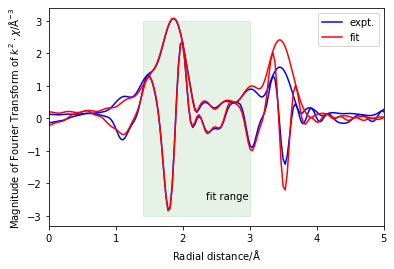

In [14]:
# plotting library
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(dset.data.r, dset.data.chir_mag, color='b')
plt.plot(dset.data.r, dset.data.chir_re, color='b', label='expt.')
plt.plot(dset.model.r, dset.model.chir_mag, color='r')
plt.plot(dset.model.r, dset.model.chir_re, color='r', label='fit')
plt.ylabel("Magnitude of Fourier Transform of $k^2 \cdot \chi$/$\mathrm{\AA}^{-3}$")
plt.xlabel("Radial distance/$\mathrm{\AA}$")
plt.xlim(0, 5)

plt.fill([1.4, 1.4, 3.0, 3.0],[-3, 3, 3, -3], color='g',alpha=0.1)
plt.text(2.35, -2.5, 'fit range')
plt.legend()
plt.show()

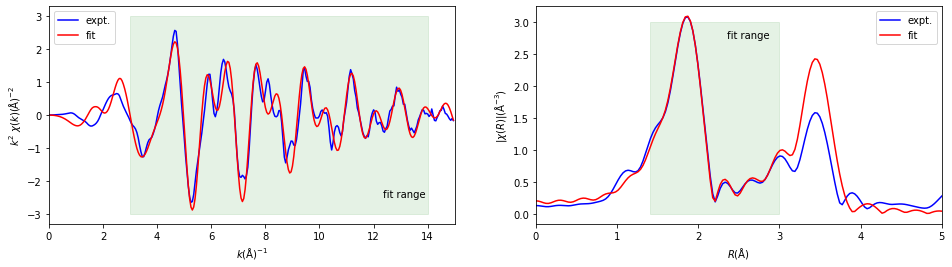

In [15]:
fig = plt.figure(figsize=(16, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
# Creating the chifit plot from scratch
#from larch.wxlib.xafsplots import plot_chifit
#plot_chifit(dset, _larch=session)
ax1.plot(dset.data.k, dset.data.chi*dset.data.k**2, color='b', label='expt.')
ax1.plot(dset.model.k, dset.model.chi*dset.data.k**2 , color='r', label='fit')
ax1.set_xlim(0, 15)
ax1.set_xlabel("$k (\mathrm{\AA})^{-1}$")
ax1.set_ylabel("$k^2$ $\chi (k)(\mathrm{\AA})^{-2}$")
ax1.fill([3.0, 3.0, 14.0, 14.0],[-3, 3, 3, -3], color='g',alpha=0.1)
ax1.text(12.35, -2.5, 'fit range')
ax1.legend()

ax2.plot(dset.data.r, dset.data.chir_mag, color='b', label='expt.')
ax2.plot(dset.model.r, dset.model.chir_mag, color='r', label='fit')
ax2.set_xlim(0, 5)
ax2.set_xlabel("$R(\mathrm{\AA})$")
ax2.set_ylabel("$|\chi(R)|(\mathrm{\AA}^{-3})$")
ax2.legend(loc='upper right')
ax2.fill([1.4, 1.4, 3.0, 3.0],[0, 3, 3, 0], color='g',alpha=0.1)
ax2.text(2.35, 2.75, 'fit range')
plt.show()
 

In [16]:
print(lp.xafs.feffit_report(out, _larch=session))

=================== FEFFIT RESULTS ====================
[[Statistics]]
   nvarys, npts       =  6, 104
   n_independent      =  12.205
   chi_square         =  371.295644
   reduced chi_square =  59.8428826
   r-factor           =  0.00290187
   Akaike info crit   =  53.6807532
   Bayesian info crit =  56.6915855
 
[[Data]]
   fit space          = 'r'
   r-range            = 1.400, 3.000
   k-range            = 3.000, 14.000
   k window, dk       = 'hanning', 1.000
   paths used in fit  = ['FeS2_feff/feff0001.dat', 'FeS2_feff/feff0002.dat', 'FeS2_feff/feff0003.dat', 'FeS2_feff/feff0004.dat']
   k-weight           = 2
   epsilon_k          = Array(mean=5.0753e-04, std=4.5904e-04)
   epsilon_r          = 0.01049725
   n_independent      = 12.205
 
[[Variables]]
   alpha          = -1.3926e-04 +/- 0.00139804   (init=  1.0000e-07)
   amp            =  0.74646925 +/- 0.03128915   (init=  1.00000000)
   enot           =  2.53728798 +/- 0.53436127   (init=  1.0000e-07)
   ss             =  0.